In [1]:
import sys
import parse_PAGE
import cv2
import line_extraction
import numpy as np
import os
import traceback
from collections import defaultdict
from scipy import ndimage
import json
import codecs
from svgpathtools import Path, Line
from scipy.interpolate import griddata
import pandas as pd


import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
def generate_offset_mapping(img, ts, path, offset_1, offset_2, max_min = None, cube_size = None):
    # cube_size = 80

    offset_1_pts = []
    offset_2_pts = []
    # for t in ts:
    for i in range(len(ts)):
        t = ts[i]
        pt = path.point(t)

        norm = None
        if i == 0:
            norm = normal(pt, path.point(ts[i+1]))
            norm = norm / dis(complex(0,0), norm)
        elif i == len(ts)-1:
            norm = normal(path.point(ts[i-1]), pt)
            norm = norm / dis(complex(0,0), norm)
        else:
            norm1 = normal(path.point(ts[i-1]), pt)
            norm1 = norm1 / dis(complex(0,0), norm1)
            norm2 = normal(pt, path.point(ts[i+1]))
            norm2 = norm2 / dis(complex(0,0), norm2)

            norm = (norm1 + norm2)/2
            norm = norm / dis(complex(0,0), norm)

        offset_vector1 = offset_1 * norm
        offset_vector2 = offset_2 * norm

        pt1 = pt + offset_vector1
        pt2 = pt + offset_vector2

        offset_1_pts.append(complexToNpPt(pt1))
        offset_2_pts.append(complexToNpPt(pt2))

    offset_1_pts = np.array(offset_1_pts)
    offset_2_pts = np.array(offset_2_pts)

    h,w = img.shape[:2]

    offset_source2 = np.array([(cube_size*i, 0) for i in range(len(offset_1_pts))], dtype=np.float32)
    offset_source1 = np.array([(cube_size*i, cube_size) for i in range(len(offset_2_pts))], dtype=np.float32)

    offset_source1 = offset_source1[::-1]
    offset_source2 = offset_source2[::-1]

    source = np.concatenate([offset_source1, offset_source2])
    destination = np.concatenate([offset_1_pts, offset_2_pts])

    source = source[:,::-1]
    destination = destination[:,::-1]

    n_w = int(offset_source2[:,0].max())
    n_h = int(cube_size)

    grid_x, grid_y = np.mgrid[0:n_h, 0:n_w]

    grid_z = griddata(source, destination, (grid_x, grid_y), method='cubic')
    map_x = np.append([], [ar[:,1] for ar in grid_z]).reshape(n_h,n_w)
    map_y = np.append([], [ar[:,0] for ar in grid_z]).reshape(n_h,n_w)
    map_x_32 = map_x.astype('float32')
    map_y_32 = map_y.astype('float32')

    rectified_to_warped_x = map_x_32
    rectified_to_warped_y = map_y_32

    grid_x, grid_y = np.mgrid[0:h, 0:w]
    grid_z = griddata(source, destination, (grid_x, grid_y), method='cubic')
    map_x = np.append([], [ar[:,1] for ar in grid_z]).reshape(h,w)
    map_y = np.append([], [ar[:,0] for ar in grid_z]).reshape(h,w)
    map_x_32 = map_x.astype('float32')
    map_y_32 = map_y.astype('float32')

    warped_to_rectified_x = map_x_32
    warped_to_rectified_y = map_y_32

    return rectified_to_warped_x, rectified_to_warped_y, warped_to_rectified_x, warped_to_rectified_y, max_min


def dis(pt1, pt2):
    a = (pt1.real - pt2.real)**2
    b = (pt1.imag - pt2.imag)**2
    return np.sqrt(a+b)

def complexToNpPt(pt):
    return np.array([pt.real, pt.imag], dtype=np.float32)

def normal(pt1, pt2):
    dif = pt1 - pt2
    return complex(-dif.imag, dif.real)

def find_t_spacing(path, cube_size):

    print('cube_size in find_t_spacing', cube_size)
    l = path.length()
    error = 0.01
    init_step_size = cube_size / l

    last_t = 0
    cur_t = 0
    pts = []
    ts = [0]
    pts.append(complexToNpPt(path.point(cur_t)))
    path_lookup = {}
    for target in np.arange(cube_size, int(l), cube_size):
        step_size = init_step_size
        for i in range(1000):
            cur_length = dis(path.point(last_t), path.point(cur_t))
            if np.abs(cur_length - cube_size) < error:
                break

            step_t = min(cur_t + step_size, 1.0)
            step_l = dis(path.point(last_t), path.point(step_t))

            if np.abs(step_l - cube_size) < np.abs(cur_length - cube_size):
                cur_t = step_t
                continue

            step_t = max(cur_t - step_size, 0.0)
            step_t = max(step_t, last_t)
            step_t = max(step_t, 1.0)

            step_l = dis(path.point(last_t), path.point(step_t))

            if np.abs(step_l - cube_size) < np.abs(cur_length - cube_size):
                cur_t = step_t
                continue

            step_size = step_size / 2.0

        last_t = cur_t

        ts.append(cur_t)
        pts.append(complexToNpPt(path.point(cur_t)))

    pts = np.array(pts)

    return ts








In [4]:
def get_basename(img_name):
    head, tail = os.path.split(img_name)
    basename = 'base_' + tail
    basename = basename[:-4]
    return basename

def handle_single_para(para_df, output_directory, flip=False):
    
    output_data = []
    num_lines = len(para_df)
    print('....', num_lines)
    if os.path.exists(para_df.image_file.iloc[0]):
        img = cv2.imread(para_df.image_file.iloc[0])
        if flip:
            img = cv2.flip(img, 1)
    else:
        print('....File not found', para_df.image_file.iloc[0])
        return ''
    basename = get_basename(para_df.image_file.iloc[0])    
    
    all_lines = ""
    
    # get rid of png/jpg extension
    
    for region in [0]:
        region_output_data = []
        #print('in region', region)
        for ind, line in enumerate(para_df.line_number):
            print('line ind', ind)
            if ind > 5:
                break
            if len(para_df.polygon_pts[ind]) == 0:
                print('No polygon pts in img', para_df.image_file.iloc[0][-15:],
                      'line number', line)
                continue
            
            line_mask = line_extraction.extract_region_mask(img, para_df.polygon_pts[ind])
            masked_img = img.copy()
            masked_img[line_mask==0] = 0
            plt.imshow(img)
            #draw_baseline(plt, para_df.baseline[ind])
            #plt.show()
            
            summed_axis0 = (masked_img.astype(float) / 255).sum(axis=0)
            summed_axis1 = (masked_img.astype(float) / 255).sum(axis=1)

            non_zero_cnt0 = np.count_nonzero(summed_axis0) / float(len(summed_axis0))
            non_zero_cnt1 = np.count_nonzero(summed_axis1) / float(len(summed_axis1))

            avg_height0 = np.median(summed_axis0[summed_axis0 != 0])
            avg_height1 = np.median(summed_axis1[summed_axis1 != 0])

            avg_height = min(avg_height0, avg_height1)
            if non_zero_cnt0 > non_zero_cnt1:
                target_step_size = avg_height0
            else:
                target_step_size = avg_height1

            print('target_step_size', target_step_size)
            paths = []
            for i in range(len(para_df.baseline[ind])-1):
                i_1 = i+1

                p1 = para_df.baseline[ind][i]
                p2 = para_df.baseline[ind][i_1]

                p1_c = complex(*p1)
                p2_c = complex(*p2)


                paths.append(Line(p1_c, p2_c))

            
            # Add a bit on the end
            tan = paths[-1].unit_tangent(1.0)
            p3_c = p2_c + target_step_size * tan
            paths.append(Line(p2_c, p3_c))

            path = Path(*paths)

            ts = find_t_spacing(path, target_step_size)
            
            print('ts:', ts)
            #Changing this causes issues in pretraining - not sure why
            target_height = 60

            rectified_to_warped_x, rectified_to_warped_y, warped_to_rectified_x, warped_to_rectified_y, max_min = generate_offset_mapping(masked_img, ts, path, 0, -2*target_step_size, cube_size = target_height)
            warped_above = cv2.remap(line_mask, rectified_to_warped_x, rectified_to_warped_y, cv2.INTER_CUBIC, borderValue=(0,0,0))

            rectified_to_warped_x, rectified_to_warped_y, warped_to_rectified_x, warped_to_rectified_y, max_min = generate_offset_mapping(masked_img, ts, path, 2*target_step_size, 0, cube_size = target_height)
            warped_below = cv2.remap(line_mask, rectified_to_warped_x, rectified_to_warped_y, cv2.INTER_CUBIC, borderValue=(0,0,0))

            above_scale =  np.max((warped_above.astype(float) / 255).sum(axis=0))
            below_scale = np.max((warped_below.astype(float) / 255).sum(axis=0))

            ab_sum = above_scale + below_scale
            above = target_step_size * (above_scale/ab_sum)
            below = target_step_size * (below_scale/ab_sum)

            above = target_step_size * (above_scale/(target_height/2.0))
            below = target_step_size * (below_scale/(target_height/2.0))
            target_step_size = above + below
            ts = find_t_spacing(path, target_step_size)
            if len(ts) <= 1:
                print('Not doing line', line)
                continue
            rectified_to_warped_x, rectified_to_warped_y, warped_to_rectified_x, warped_to_rectified_y, max_min = generate_offset_mapping(masked_img, ts, path, below, -above, cube_size=target_height)

            rectified_to_warped_x = rectified_to_warped_x[::-1,::-1]
            rectified_to_warped_y = rectified_to_warped_y[::-1,::-1]

            warped_to_rectified_x = warped_to_rectified_x[::-1,::-1]
            warped_to_rectified_y = warped_to_rectified_y[::-1,::-1]

            warped = cv2.remap(img, rectified_to_warped_x, rectified_to_warped_y, cv2.INTER_CUBIC, borderValue=(255,255,255))

            
            
            mapping = np.stack([rectified_to_warped_y, rectified_to_warped_x], axis=2)

            top_left = mapping[0,0,:] / np.array(img.shape[:2]).astype(np.float32)
            btm_right = mapping[min(mapping.shape[0]-1, target_height-1), min(mapping.shape[1]-1, target_height-1),:] / np.array(img.shape[:2]).astype(np.float32)


            line_points = []
            for i in range(0,mapping.shape[1],target_height):

                x0 = float(rectified_to_warped_x[0,i])
                x1 = float(rectified_to_warped_x[-1,i])

                y0 = float(rectified_to_warped_y[0,i])
                y1 = float(rectified_to_warped_y[-1,i])

                line_points.append({
                    "x0": x0, 
                    "x1": x1, 
                    "y0": y0, 
                    "y1": y1, 
                })
                
                
                                
            ###Mehreen add for viewing

            
            #print("****", line_points)
            for indexs,coord in enumerate(line_points):
                if indexs > 0:
                    plt.plot([x, coord["x0"]], [y, coord["y0"]], color='blue', linewidth=.5)
                    plt.plot([x1, coord["x1"]], [y1, coord["y1"]], color='red', linewidth=.5)
                x = coord["x0"]
                y = coord["y0"]
                x1 = coord["x1"]
                y1 = coord["y1"]
                #rect = patches.Rectangle((x, y), np.abs(x-coord[2]), np.abs(y-coord[3]), facecolor='green')
                rect = patches.Rectangle((x, y), 50, 50, facecolor='blue')
                rect1 = patches.Rectangle((x1, y1), 50, 50, facecolor='red')
                plt.gca().add_patch(rect)  
                plt.gca().add_patch(rect1)
            rect0 = patches.Rectangle((line_points[0]["x0"], line_points[0]["y0"]), 50, 50, facecolor='black') 
            plt.gca().add_patch(rect0)
            
             ## ENd mehreen add for view   
                
            
            output_file = os.path.join(output_directory, 
                          basename, "{}~{}~{}.png".format(basename, region, line))
            warp_output_file = os.path.join(output_directory, basename, "{}-{}.png".format(basename, line))
            warp_output_file_save = os.path.join(basename, "{}-{}.png".format(basename, str(len(region_output_data))))
            save_file = os.path.join(basename, "{}~{}~{}.png".format(basename, region, line))
            region_output_data.append({
                "gt": para_df.ground_truth[ind],
                "image_path": save_file,
                "sol": line_points[0],
                "lf": line_points,
                "hw_path": warp_output_file #MEhreen commentwarp_output_file_save
            })
            #print('****', output_file)
            if not os.path.exists(os.path.dirname(output_file)):
                try:
                    os.makedirs(os.path.dirname(output_file))
                    
                except OSError as exc:
                    raise Exception("Could not write file")

            cv2.imwrite(warp_output_file, warped)

        output_data.extend(region_output_data)

    plt.show() 
    if len(region_output_data) == 0:
        return ''
        
    output_data_path =os.path.join(output_directory, basename, "{}.json".format(basename))
    if not os.path.exists(os.path.dirname(output_data_path)):
        os.makedirs(os.path.dirname(output_data_path))

#    with open(output_data_path, 'w') as f:
#        json.dump(output_data, f)

    return output_data  
    


In [5]:
def convert_str_to_int_tuples(df_col):
    tmp_col = []
    for ind, item in enumerate(df_col):
        if not pd.isna(item):
            item = eval(item)    
            tmp_col.append([(round(x[0]), round(x[1])) for x in item])
        else:
            tmp_col.append([])
    return tmp_col

def rotate_polygon(p):
    if len(p) == 8 or len(p) == 7:
        poly = p[4:]
        poly.extend(p[0:4])
        return poly
    if len(p) == 4:
        poly = [p[2], p[3], p[0], p[1]]
        return poly
    else:
        print("something wrong", p)
        return []
    
def rotate_poly_list(df_col):
    poly_list = [rotate_polygon(p) for p in df_col]
    return poly_list


def rotate_baseline_list(df_col):
    b_list = [b[::-1] for b in df_col]
    return b_list
    
   

In [6]:
def draw_baseline(plt, xy_pts, color='red'):
    for pts1, pts2 in zip(xy_pts, xy_pts[1:]):
        plt.plot([pts1[0], pts2[0]], [pts1[1], pts2[1]], color=color)
        

***
cropped: (4068, 2291, 3) (85, 985) (2375, 5052)


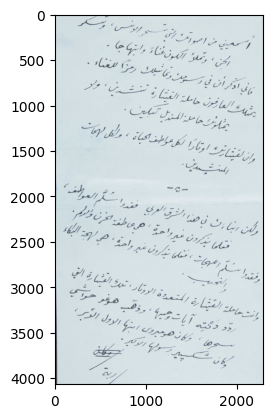

In [21]:
def get_cropped_region(para_df, img):
    ht, width = img.shape[:2]
    upper_left = (width-1, ht-1)
    lower_right = (0, 0)
    for poly_pts in para_df.polygon_pts:
        #poly_pts = eval(poly_pts)
        for pt in poly_pts:
            upper_left = (min(pt[0], upper_left[0]), min(pt[1], upper_left[1]))
            lower_right = (max(pt[0], lower_right[0]), max(pt[1], lower_right[1]))
    # Make sure upper_left and lower_right are within image bounds
    upper_left = (max(0, upper_left[0]), max(0, upper_left[1]))
    lower_right = (min(width-1, lower_right[0]), min(ht-1, lower_right[1]))
        
    if len(img.shape)==2:
        img = img[upper_left[1]: lower_right[1]+1, upper_left[0]: lower_right[0]+1]
    else:
        img = img[upper_left[1]: lower_right[1]+1, upper_left[0]: lower_right[0]+1, :]
    print('cropped:', img.shape, upper_left, lower_right)
    return img

# Subtract all x-coord from img_width as for Arabic we flip the image horizontally 
# Right to left reading order
# Set reverse=True for baseline so that reading order becomes left to righ
def flip_x_coord(df_col, img_width, reverse=False):
    new_col = []
    for ind, item in enumerate(df_col):
        flipped = [(img_width-x, y) for (x,y) in item]
        if reverse:
            flipped = flipped[::-1]
        new_col.append(flipped)
    return new_col
        

def get_img_dim(filename):
    img = cv2.imread(filename)
    ht, width = img.shape[:2]
    return (ht, width)

out_path = '/home/msaeed3/mehreen/datasets/MoiseK/datasets_sfr/'

check_file = 'AR51_008.jpg'

set_name = 'all_01'

df = pd.read_csv(os.path.join(out_path, set_name + '.csv'))
df.baseline = convert_str_to_int_tuples(df.baseline)

df.polygon_pts = convert_str_to_int_tuples(df.polygon_pts)

files = df.image_file

all_ground_truth = []
for img_path in set(files):    
    if check_file in img_path:
        print('***')
        para_df = df[df.image_file == img_path]  
        _, width = get_img_dim(img_path)
        para_df = para_df.copy()
        para_df = para_df.reset_index(drop=True)
        img = cv2.imread(img_path)
        img_2 = get_cropped_region(para_df, img)
        plt.imshow(img_2)
        plt.show()
        #print('before: ', para_df.baseline[0])
        #para_df.baseline = flip_x_coord(para_df.baseline, width, reverse=False)
        #print('after: ', para_df.baseline[0])
        #para_df.polygon_pts = flip_x_coord(para_df.polygon_pts, width) 

        #json_data = handle_single_para(para_df, out_path+set_name, flip=True)       
        
        
        

In [ ]:
sys.path.append('../../../coords')
import points 


# Chunks_len ignored if chunk_len_auto is True
def get_baseline_chunks(poly_pts, chunks_len=300, chunk_len_auto=True):
    baseline = []
    poly_pts = points.expand_poly(poly_pts)
    
    polyy = patches.Polygon(poly_pts, edgecolor='blue', fill=False)  
    plt.gca().add_patch(polyy) 
    
    p = np.array(poly_pts)
    
    max_x, max_y = np.max(p, 0)
    min_x, min_y = np.min(p, 0)
    
    # Decide chunks_len
    if chunk_len_auto:
        if (len(poly_pts) >= 250):
            total_chunks = 15
        else:
            total_chunks = int(np.ceil(len(poly_pts)/50))
        chunks_len = int((max_x-min_x)/total_chunks)
    else:
        total_chunks = int((max_x-min_x)/chunks_len)
    
    #print('expanded len', len(poly_pts), 'total chunks', total_chunks)
    for i in range(1, total_chunks+1):
        p1 = [pt for pt in p if (pt[0]-min_x)>=(i-1)*chunks_len and (pt[0]-min_x)<i*chunks_len]
        #print(p1)
        if i == total_chunks:
            p1 = [pt for pt in p if (pt[0] - min_x)>=(i-1)*chunks_len]
            
        ppx = [x for (x,y) in p1]
        ppy = [y for (x,y) in p1]
        plt.scatter(ppx, ppy, color=['red','blue','green'][i%3], s=5)
            
            
        b = points.get_baseline_regression(p1, num_pts=12)
        
        # Points are in ascending order (increasing x - left to right) 
        if len(baseline) != 0:
            # This will smooth out the line
            # Get rid of last 4 points and connect the point with next 4 points
            baseline = baseline[:-4]
            baseline.extend(b[4:])
            if i == total_chunks:
                baseline.extend(b[-1:])
        else:
            baseline = b
        draw_baseline(plt, b, color=['red','blue','green'][i%3])
   
    return baseline


img = cv2.imread(para_df.image_file[0])

img = cv2.flip(img, 1)
plt.imshow(img)
for ind, (p, b) in enumerate(zip(para_df.polygon_pts, para_df.baseline)):
    if ind!=5:
        continue
    #print('poly', p)
    
    #draw_baseline(plt, b, color='black')
    poly = patches.Polygon(p, edgecolor='blue', fill=False)  
    plt.gca().add_patch(poly) 
    #bl = points.get_baseline_chunks(p)
    draw_baseline(plt, b, color='red')
    #print('baseline', bl)
    
    
#    break
plt.show()



In [ ]:
np.array([1,2,3,4]).astype(list)
a  = [(1,2)]
b = [(1,2),(3,4)]
b.extend(a)
print(b)

In [ ]:
img = cv2.imread('../../data/Train-A/000001.jpg')
plt.imshow(img)


with open('/home/msaeed3/mehreen/source/start_follow_read/data/train_a/000001/000001.json') as fin:
    obj = json.load(fin)
for ind, o in enumerate(obj):
    if ind%2==1:
        continue
    col = ['red', 'green', 'blue'][ind%3]
    for c in o['lf']:
        plt.scatter([c['x0'],c['x1']], [c['y0'],c['y1']], color=col, s=2)
    plt.scatter([o['sol']['x0'], o['sol']['x1']], [o['sol']['y0'], o['sol']['y1']], s=5, color='black')            